import packages
------------------

Some packages are installed automatically if you use Anaconda. As pytorch is used here, you are expected to install that in your machine. 

In [1]:
from google.colab import drive
# drive.flush_and_unmount()
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
# added to be able to run in Google Colab
import sys
sys.path.append('/content/gdrive/MyDrive/UTRECHT/utils')
sys.path.insert(0,'/content/gdrive/MyDrive/UTRECHT')

import utils

In [3]:
from __future__ import print_function, division
import os, random, time, copy
from skimage import io, transform, morphology, feature, measure
from skimage.morphology import dilation, square, binary_opening
from skimage.color import rgb2gray
import numpy as np
import os.path as path
import scipy.io as sio
import scipy
from scipy import misc
from scipy import ndimage, signal
from scipy.ndimage import gaussian_filter
import pickle
import sys
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import PIL.Image
from io import BytesIO
from skimage import data, img_as_float
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
import pandas as pd 
import matplotlib.patheffects as path_effects
import csv

from skimage.filters import threshold_otsu

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler 
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms

# sys.path.append('/home/skong2/project/dpff4ldl')
# from utils.metrics import *
# from losses import *

from utils.flow_functions import *
from utils.dataset import *
from utils.network_arch import *
from utils.trainval_detSegDistTransform import *

import warnings # ignore warnings
warnings.filterwarnings("ignore")
print(sys.version)
print(torch.__version__)

3.10.11 (main, Apr  5 2023, 14:15:10) [GCC 9.4.0]
2.0.0+cu118




Evaluation and Visualization
-----

In [4]:
# Here define the path, which is used to save the log and trained model in training process

project_name = 'Finetuning_allSlides'
trial = 'Trial_02' 

# cpu or cuda
device ='cpu'
if torch.cuda.is_available(): 
    device='cuda:0'
print(device)

freqShow = 50
weight_reg = 2.0    # Balances regression loss with segmentation loss. Value chosen based on past investigation.
weight_background = 0.1   # For regression loss only, downweights background pixels to highlight foreground pollen

#model parameters
batch_size = 4
newSize = [1024,1024]       # set to crop size, to tell model what size tensor to expect
total_epoch_num = 30      # total number of epoch in training
base_lr =0.0005           # base learning rate
scaleList = [0]           # the number of output layer for U-net

exp_dir = '/content/gdrive/MyDrive/ENSO_project/02_det/exp' # experiment directory
exp_dir = os.path.join(exp_dir, project_name)
save_dir = os.path.join(exp_dir, trial)  # Location to read trained models.

cuda:0


In [5]:
eval_dir = '/content/gdrive/MyDrive/ENSO_project/02_det/eval' 
eval_dir = os.path.join(eval_dir, project_name, trial) 
if not os.path.exists(eval_dir): 
    os.makedirs(eval_dir)

In [6]:
path_to_image = '/content/gdrive/MyDrive/ENSO_project/01_data/02_tiles'
path_to_mask = '/content/gdrive/MyDrive/ENSO_project/01_data/04_masks'
path_to_annot= '/content/gdrive/MyDrive/ENSO_project/01_data/03_annot'   ### format of annot: [[label, abs_x_center, abs_y_center, rel_x_center,rel_y_center, r]]
with open(os.path.join(save_dir,'dbinfo.pkl'), 'rb') as handle:
    dbinfo = pickle.load(handle)    
    
dbinfo.keys(), len(dbinfo['train_det_list']), len(dbinfo['test_det_list'])

(dict_keys(['train_det_list', 'test_det_list']), 1226, 306)

In [7]:
################## init model ###################
path_to_save_paramOnly = path.join(save_dir, 'bestValModel_encoder.paramOnly')

curmodel = PollenDet_SegDistTransform(34, scaleList=scaleList, pretrained=False)
curmodel.encoder.encoder.conv1 = nn.Conv2d(27, 64, (7, 7), (2, 2), (3, 3), bias=False) #change dimensions of the first layer in the encoder
curmodel.load_state_dict(torch.load(path_to_save_paramOnly)) #, map_location=torch.device('cpu')
curmodel.to(device);    
#print(curmodel.state_dict)
curmodel.eval()
#curmodel.train()
curmodel.training = False
print(curmodel.training)

False


In [8]:
class PollenDet4Eval(Dataset):
    def __init__(self, path_to_image=path_to_image,
                 path_to_annot=path_to_annot,
                 path_to_mask=path_to_mask,
                 dbinfo=dbinfo,
                 size=newSize, 
                 set_name='test'):
        
        self.path_to_image = path_to_image
        self.path_to_annot = path_to_annot
        self.path_to_mask = path_to_mask
        self.transform = transform
        self.dbinfo = dbinfo
        if set_name=='val':
            set_name = 'test'
        self.set_name = set_name        
        self.size = size
        self.resizeFactor = size[0]/1000
        
        self.sampleList = self.dbinfo[set_name+'_det_list']

        self.TFNormalize = transforms.Normalize([0.5] * 27, [0.5]*27)
        self.current_set_len = len(self.sampleList)
        
        self.TF2tensor = transforms.ToTensor()
        self.TF2PIL = transforms.ToPILImage()
        self.TFresize = transforms.Resize((self.size[0],self.size[1]))

    def __len__(self):        
        return self.current_set_len
    
    def __getitem__(self, idx):        
        current_example= self.sampleList[idx]

        current_image_path= os.path.join(self.path_to_image, current_example[0], current_example[1])
        current_distTransform_path=os.path.join(self.path_to_mask, current_example[0], current_example[1])
        curPickleName = os.path.join(self.path_to_annot, current_example[0])

        imagestack_array = []
        for file in sorted(os.listdir(current_image_path)):
          if file.endswith('.png'):
            slice = Image.open(os.path.join(current_image_path, file))
            imagestack_array.append(np.asarray(slice).astype(np.float32)/255)
        image = np.block(imagestack_array)
        if image.shape[2] <27:
          pad_val = 27-image.shape[2]
          npad = ((0, 0), (0,0), (0,pad_val))
          image= np.pad(image, pad_width=npad, mode='constant', constant_values=0)
        

        for file in os.listdir(current_distTransform_path):
          if file.endswith('.png'):
            mask = Image.open(os.path.join(current_distTransform_path, file))
            mask=np.array(mask)
            mask=np.expand_dims(mask, axis=2)

        for file in os.listdir(curPickleName):
          if file.endswith(os.path.join(current_example[1]+'.pkl')):
            with open(os.path.join(curPickleName, file), 'rb') as handle:
              annot = pickle.load(handle)

        # times = np.random.randint(1)
        # if times!=0:
        #     if times==1:
        #         for i in range(annot['coord_peaks'].shape[0]):
        #             y, x = annot['coord_peaks'][i]
        #             annot['coord_peaks'][i][0] = annot['coord_peaks'].shape[1]-x
        #             annot['coord_peaks'][i][1] = y
        #             annot['size'] = (annot['size'][1], annot['size'][0])                    
        #     elif times==2:
        #         for i in range(annot['coord_peaks'].shape[0]):
        #             y, x = annot['coord_peaks'][i]
        #             annot['coord_peaks'][i][0] = annot['coord_peaks'].shape[0]-y
        #             annot['coord_peaks'][i][1] = annot['coord_peaks'].shape[1]-x
        #     elif times==3:
        #         for i in range(annot['coord_peaks'].shape[0]):
        #             y, x = annot['coord_peaks'][i]
        #             annot['coord_peaks'][i][0] = x
        #             annot['coord_peaks'][i][1] = annot['coord_peaks'].shape[0]-y
        #             annot['size'] = (annot['size'][1], annot['size'][0])
        #     #for _ in range(times):
        #     image = np.rot90(image, times).copy()
        

        label = np.copy(mask)         # 11/30/21 added
        label[label > 0] = 1          # 11/30/21 added       

        image_label = np.concatenate((image, label, mask), axis=2) #12/13/21 added


        mask_distanceTransform = np.copy(mask)     #11/18/21 edited
        
        labelOrgSize = np.copy(mask)
        labelOrgSize = torch.from_numpy(labelOrgSize).unsqueeze(0).unsqueeze(0).squeeze(4)
        # labelOrgSize = F.interpolate(labelOrgSize, size=(self.size[0], self.size[1]), mode='nearest')

        mask_distanceTransform = mask_distanceTransform.astype(np.float32)  # /100.0/self.resizeFactor  

        image = self.TF2tensor(image)
        label = torch.from_numpy(label).unsqueeze(0)
        mask_distanceTransform = torch.from_numpy(mask_distanceTransform).unsqueeze(0) 

        image = image.unsqueeze(0)
        label = label.unsqueeze(0)        
        mask_distanceTransform = mask_distanceTransform.unsqueeze(0)       

        height,width,layer = image_label.shape
        # if height > self.size[0] or width > self.size[1]:
        crop0 = image_label[0:self.size[0], 0:self.size[0],:]
        crop1 = image_label[0:self.size[0], width-self.size[0]:,:]
        crop2 = image_label[height-self.size[0]:, 0:self.size[0],:]
        crop3 = image_label[height-self.size[0]:, width-self.size[0]:,:]

        croplist = [crop0, crop1, crop2, crop3]
        imgList=[]
        labelList=[]
        mask_DTList=[]

        for idx2 in range(len(croplist)):
          image_label = croplist[idx2]
          image_label = self.TF2tensor(image_label)
          image_label = image_label.unsqueeze(0)  
          image = torch.narrow(image_label, 1, 0, image_label.shape[1]-2) 
          label=torch.narrow(image_label, 1, image_label.shape[1]-2, 1) 
          mask_distanceTransform=torch.narrow(image_label, 1, image_label.shape[1]-1, 1)

          image_label = image_label.squeeze(0)
          image = image.type(torch.float)
          image = self.TFNormalize(image)

          imgList.append(image)
          labelList.append(label)
          mask_DTList.append(mask_distanceTransform)

        image = torch.concat(imgList)
        label = torch.concat(labelList)
        mask_distanceTransform = torch.concat(mask_DTList)   #indent up to here if using conditional

        image = image.squeeze(0)
        label = label.squeeze(0)
        mask_distanceTransform = mask_distanceTransform.squeeze(0)
        labelOrgSize = labelOrgSize.squeeze(0)

        return image, label, mask_distanceTransform, labelOrgSize, current_example


In [57]:
set_name = 'test' #'test'
det_datasets = PollenDet4Eval(path_to_image=path_to_image,
                              path_to_annot=path_to_annot,
                              dbinfo=dbinfo, size=newSize, set_name=set_name)

dataloaders = DataLoader(det_datasets,
                         batch_size=1,
                         shuffle=False, 
                         num_workers=8) # num_work can be set to batch_size



In [41]:
def create_circular_mask(mask, center, radius, value=1):
    h, w = mask.shape[:2]
    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((Y - center[0])**2 + (X-center[1])**2)

    tmpMask = dist_from_center <= radius
    mask[tmpMask] = value
    
    return mask

In [42]:
def create_reverse_mask(mask, center, radius, value=1):
    h, w = mask.shape[:2]
    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((Y - center[0])**2 + (X-center[1])**2)

    tmpMask = dist_from_center > radius
    mask[tmpMask] = value
    
    return mask

In [43]:
def IOU(box1, box2):
    """
We assume that the box follows the format:
box1 = [x1,y1,x2,y2], and box2 = [x3,y3,x4,y4],
where (x1,y1) and (x3,y3) represent the top left coordinate,
and (x2,y2) and (x4,y4) represent the bottom right coordinate
    """
    x1, y1, x2, y2 = box1	
    x3, y3, x4, y4 = box2
    
    assert x1 < x2
    assert y1 < y2
    assert x3 < x4
    assert y3 < y4

    # determine the coordinates of the intersection rectangle
    x_left = max(x1, x3)
    y_top = max(y1, y3)
    x_right = min(x2, x4)
    y_bottom = min(y2, y4)

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    # The intersection of two axis-aligned bounding boxes is always an
    # axis-aligned bounding box
    intersection_area = (x_right - x_left + 1) * (y_bottom - y_top + 1)
    
    # compute the area of both AABBs
    bb1_area = (x2 - x1) * (y2 - y1)
    bb2_area = (x4 - x3) * (y4 - y3)

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.1
    return iou

In [44]:
def nms(boxes, conf_threshold=0.1, iou_threshold=0.5):
    bbox_list_thresholded = []
    bbox_list_new = []
    bbox_list_new_txt = []
    # detMask_info = detMask_info

    # Stage 1: sort boxes, filter out boxes with low confidence
    boxes_sorted = sorted(boxes, reverse=True, key = lambda x : x[1])
    for box in boxes_sorted:
        if box[1] > conf_threshold:
            bbox_list_thresholded.append(box)
        else:
            pass
    # Stage 2: loop through the boxes, remove boxes with high IoU
    while len(bbox_list_thresholded) > 0:
        current_box = bbox_list_thresholded.pop(0)
        bbox_list_new.append(current_box)
        current_box_txt = (current_box[0], str(current_box[1]) , str(current_box[2]), str(current_box[3]), str(current_box[4]), str(current_box[5]) )
        current_box_txt = ' '.join(current_box_txt)
        bbox_list_new_txt.append(current_box_txt)

        for box in bbox_list_thresholded:
            if current_box[0] == box[0]:
                iou = IOU(current_box[2:], box[2:])
                # print(iou)
                if iou > iou_threshold:
                    bbox_list_thresholded.remove(box)
                    # detMask_info.remove()

    return  bbox_list_new, bbox_list_new_txt

# Testing exporting crops, masks, labels (optional)

In [ ]:
class_dir = os.path.join('/content/gdrive/MyDrive/ENSO_project/01_data','05_crops')
if not os.path.exists(class_dir):
  os.makedirs(class_dir)

class_dir = os.path.join(class_dir, project_name, trial)
if not os.path.exists(class_dir):
  os.makedirs(class_dir)

In [ ]:
class_dir_stacks = os.path.join(class_dir, 'Stacks')
class_labels = os.path.join(class_dir_stacks, 'Labels')
if not os.path.exists(class_labels): 
    os.makedirs(class_labels)

class_imgs = os.path.join(class_dir_stacks, 'Images')
if not os.path.exists(class_imgs): 
    os.makedirs(class_imgs)

class_masks = os.path.join(class_dir_stacks, 'Masks')
if not os.path.exists(class_masks): 
    os.makedirs(class_masks)

GT_masks = os.path.join(class_dir_stacks, 'GT_Masks')
if not os.path.exists(GT_masks): 
    os.makedirs(GT_masks)

false_det_labels = os.path.join(class_dir_stacks, 'False_Det','Labels')
if not os.path.exists(false_det_labels): 
    os.makedirs(false_det_labels)

false_det_imgs = os.path.join(class_dir_stacks, 'False_Det','Images')
if not os.path.exists(false_det_imgs): 
    os.makedirs(false_det_imgs)

false_det_masks = os.path.join(class_dir_stacks, 'False_Det', 'Masks')
if not os.path.exists(false_det_masks): 
    os.makedirs(false_det_masks)


In [ ]:
plt.imshow(curmask_OrgSize_binary)

In [ ]:
# create detection mask using peaks and predicted radius
# coord_peaks = feature.peak_local_max(voting4center, min_distance=25, exclude_border=False) #originally min_distance =5, changed to 25

centerMask = voting4center*0
detMask = voting4center*0
predRadiusList = []
detection_info2 = []

size = (400,400)

for i in range(coord_peaks.shape[0]):
    #############################create full image detection mask##########################################################
    y, x = coord_peaks[i]
    #centerMask[y, x] = 1
    centerMask[y-10:y+10, x-10:x+10] = 1

    left = int(x-(size[0]/2))
    left=max(left,0)
    top = int(y-(size[0]/2))
    top=max(top,0)
    right = int(x+(size[0]/2))
    right=max(right,0)
    bottom = int(y+(size[0]/2))
    bottom=max(bottom,0)

    tmpCrop = softmax[top:bottom, left:right]
    thresh = threshold_otsu(tmpCrop) 
    tmpCrop = tmpCrop> thresh # binarize
    tmpCrop= measure.label(tmpCrop, background=0)
    props = measure.regionprops(tmpCrop) #get the properties of the connected components

    diameter = [prop.major_axis_length for prop in props]   #diameter for connected components
    radius = int(max(diameter)/2)

    predRadiusList += [radius]

    tmpMask = voting4center*0
    tmpMask = create_circular_mask(tmpMask, [y, x], predRadiusList[i], value=1)

    class_name="det"
    leftBb = x-radius
    leftBb = max(leftBb,0)
    topBb = y-radius
    topBb= max(topBb,0)
    rightBb = x+radius
    rightBb = max(rightBb, 0)
    bottomBb = y+radius
    bottomBb = max(bottomBb,0)

    masked_softmax = np.ma.masked_where(tmpMask==0, softmax) 
    confidence = np.nanmean(masked_softmax)
    bbox_info2 = [class_name, confidence, leftBb, topBb, rightBb, bottomBb]

    detMask = create_circular_mask(detMask, [y, x], predRadiusList[i], value=i+1)
    detection_info2.append(bbox_info2)

    #############################crop detection mask##########################################################
    # tmpMask = tmpMask.astype(int)
    crop_mask = tmpMask[top:bottom, left:right]
    crop_gt_mask = curmask_OrgSize_binary[top:bottom, left:right]

    #############################crop image and make arrays of slices##########################################################
    slices = []

    for idx in range(len(slice_path)):
      # tmpImg = mpimg.imread(slice_path[idx])
      # tmpImg = tmpImg[top:bottom, left:right]

      img_slice =  PIL.Image.open(slice_path[idx])
      img_slice = np.array(img_slice)[top:bottom, left:right]
      slices.append(img_slice)

    ############################ attach class label ######################################################## 
    pred_bb = [leftBb, topBb, rightBb, bottomBb]
    gt_bb_list = []

    for j in range(len(class_label_full)):
        cur_class_label_full = class_label_full[j]
        code = str(cur_class_label_full[4])
        tileId = cur_class_label_full[8]
        pollenId = cur_class_label_full[9]

        gt_leftBb = int(cur_class_label_full[0])
        gt_topBb= int(cur_class_label_full[1])
        gt_rightBb = int(cur_class_label_full[0]) + int(cur_class_label_full[2])
        gt_bottomBb = int(cur_class_label_full[1]) + int(cur_class_label_full[3])

        gt_bb = [gt_leftBb,gt_topBb,gt_rightBb,gt_bottomBb]
        gt_bb_list.append(gt_bb)

        iou = IOU(gt_bb,pred_bb)
        print(iou)
        if iou>0.3:
            print(code)
            print(iou)

            # write label info to CSV 
            fields = ['Folder', 'TileId','PollenId', 'LeftBb', 'TopBb', 'RightBb', 'BottomBb', 'Y','X','Radius','Code', 'Det_Confidence']
            label = [current_example[0], tileId, pollenId, leftBb, topBb, rightBb, bottomBb, y, x, radius, code, confidence]

            label_path = os.path.join(class_labels, code)
            if not os.path.exists(label_path): 
                os.makedirs(label_path)
                
            k = 1
            label_filename = "{}/{}_{}{}".format(label_path, current_example, k, '.csv')
            while os.path.exists(label_filename):
                label_filename = "{}/{}_{}{}".format(label_path, current_example, k, '.csv')
                k += 1

            with open(label_filename, 'w') as f:
                write = csv.writer(f)

                # write.writerow(fields)
                # write.writerow(label)


            # save slices of cropped image
            img_path = os.path.join(class_imgs,code)
            if not os.path.exists(img_path): 
                os.makedirs(img_path)

            k = 1
            img_path_2 = os.path.join(img_path, current_example + '_' + str(k))
            while os.path.exists(img_path_2):
                img_path_2 = os.path.join(img_path, current_example + '_' + str(k))
                k += 1

            for m in range(len(slices)):
                if not os.path.exists(img_path_2): 
                    os.makedirs(img_path_2)             
                img_filename = "{}/{}{}".format(img_path_2,'slice' + str(m),'.bmp')

                if isinstance(slices[m], np.ndarray):
                    img_slice = PIL.Image.fromarray(slices[m])
                img_slice.save(img_filename)            

            # save cropped mask
            mask_path = os.path.join(class_masks,code)
            if not os.path.exists(mask_path): 
                os.makedirs(mask_path)

            k=1
            mask_filename = "{}/{}_{}{}".format(mask_path, current_example, k, '.bmp')
            while os.path.exists(mask_filename):
                mask_filename = "{}/{}_{}{}".format(mask_path, current_example, k, '.bmp')
                k += 1

            if isinstance(crop_mask, np.ndarray):
                crop_mask = PIL.Image.fromarray((crop_mask * 255).astype(np.uint8))
            # crop_mask.save(mask_filename)

            # save gt mask
            gt_mask_path = os.path.join(GT_masks,code)
            if not os.path.exists(gt_mask_path ): 
                os.makedirs(gt_mask_path)

            k=1
            gt_mask_filename = "{}/{}_{}{}".format(gt_mask_path, current_example, k, '.bmp')
            while os.path.exists(mask_filename):
                mask_filename = "{}/{}_{}{}".format(gt_mask_path, current_example, k, '.bmp')
                k += 1

            if isinstance(crop_gt_mask, np.ndarray):
                crop_gt_mask = PIL.Image.fromarray((crop_gt_mask * 255).astype(np.uint8))
            crop_gt_mask.save(gt_mask_filename)            

    if all(IOU(gt_bb_list[j],pred_bb)<0.3 for j in range(len(gt_bb_list))):
        # write label info to CSV 
        fields = ['Folder','LeftBb', 'TopBb', 'RightBb', 'BottomBb', 'Y','X','Radius','Code', 'Det_Confidence']
        label = [current_example, leftBb, topBb, rightBb, bottomBb, y, x, radius, confidence]
            
        k = 1
        label_filename = "{}/{}_{}{}".format(false_det_labels, current_example, k, '.csv')
        while os.path.exists(label_filename):
            label_filename = "{}/{}_{}{}".format(false_det_labels, current_example, k, '.csv')
            k += 1

        with open(label_filename, 'w') as f:
            write = csv.writer(f)

            write.writerow(fields)
            write.writerow(label)

        k = 1
        false_det_img_dir = os.path.join(false_det_imgs, current_example + '_' + str(k))
        while os.path.exists(false_det_img_dir):
            false_det_img_dir = os.path.join(false_det_imgs, current_example + '_' + str(k))
            k += 1

        for m in range(len(slices)):
            if not os.path.exists(false_det_img_dir): 
                os.makedirs(false_det_img_dir)             
            img_filename = "{}/{}{}".format(false_det_img_dir ,'slice' + str(m),'.bmp')

            if isinstance(slices[m], np.ndarray):
                img_slice = PIL.Image.fromarray(slices[m])
            img_slice.save(img_filename)

        k=1
        mask_filename = "{}/{}_{}{}".format(false_det_masks, current_example, k, '.bmp')
        while os.path.exists(mask_filename):
            mask_filename = "{}/{}_{}{}".format(false_det_masks, current_example, k, '.bmp')
            k += 1

        if isinstance(crop_mask, np.ndarray):
            crop_mask = Image.fromarray((crop_mask * 255).astype(np.uint8))
        crop_mask.save(mask_filename)

# plt.imshow(img_slice)
print(len(slices))
plt.imshow(slices[m])

In [ ]:
# export gt labels, images, masks

# rea

gt_bb_list = []

for j in range(len(class_label_full)):
    cur_class_label_full = class_label_full[j]
    code = str(cur_class_label_full[4])
    tileId = cur_class_label_full[8]
    pollenId = cur_class_label_full[9]

    gt_leftBb = int(cur_class_label_full[0])
    gt_topBb= int(cur_class_label_full[1])
    gt_rightBb = int(cur_class_label_full[0]) + int(cur_class_label_full[2])
    gt_bottomBb = int(cur_class_label_full[1]) + int(cur_class_label_full[3])

    gt_bb = [gt_leftBb,gt_topBb,gt_rightBb,gt_bottomBb]




In [ ]:
current_image_path= os.path.join(path_to_image, current_example[0])
path_to_imdb = os.path.join(str(current_image_path), 'annot.csv')
imdb = pd.read_csv(path_to_imdb, dtype=object)

class_label_coord = pd.DataFrame(imdb, columns = ['X Coord of Bb','Y Coord of Bb','Bb Width','Bb Height'])
class_label_coord = class_label_coord.to_numpy().astype(int)

class_labels=pd.DataFrame(imdb, columns=['Code', 'Family','Genus','Species'])
print(class_labels)

class_labels= class_labels.to_numpy()

In [ ]:
numSample2Show = 1
figWinNumHeight, figWinNumWidth = 3, 2
plt.figure(figsize=(10,10), dpi=128, facecolor='w', edgecolor='k') # figsize -- inch-by-inch
plt.clf()
subwinCount = 1    

plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
plt.imshow(centerMask)
plt.title('centerMask')
plt.colorbar()
# plt.imsave(os.path.join(eval_save_to_folder, 'centerMask.png'), centerMask, format='png')

plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
plt.imshow(detMask)
plt.title('detMask')
plt.colorbar()
# plt.imsave(os.path.join(eval_save_to_folder, 'detMask.png'), tmpImg, format='png')

plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
slice_path=[]
current_image_path= os.path.join(path_to_image, current_example[0])
for file in sorted(os.listdir(str(current_image_path))):
    if file.endswith('.bmp'):
      slice = os.path.join(str(current_image_path), file)
      slice_path.append(slice)
img = mpimg.imread(slice_path[5])
masked = np.ma.masked_where(detMask == 0, detMask)
for coord, labels in zip(class_label_coord,class_labels):
    Xcoord = int(coord[0]+(0.5*coord[3]))
    Ycoord = int(coord[1]+(0.5*coord[2]))
    plt.text(Xcoord, Ycoord, labels[0],
             fontsize=10,
             color='black', path_effects=[path_effects.withStroke(linewidth=2, foreground="w")])
plt.imshow(img, interpolation='none')
plt.imshow(masked, 'viridis', interpolation='none', alpha=0.5)    #'jet' also works as color
plt.title('detMask-overlay')
plt.colorbar()

plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
plt.imshow(softmax)
plt.title('pred-softmax')
plt.colorbar()

plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
tmpImg = mask_OrgSize
plt.imshow(tmpImg)
#plt.axis('off')
plt.title('dist-transform-grnd')
plt.colorbar()


plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
plt.imshow(pred_distanceTransform)
plt.title('dist-transform-pred')
plt.colorbar()

In [ ]:
iterCount, sampleCount = 0, 0
phase = 'train'
for sample in dataloaders: 
            
    curImg, curLabel, curMask, curMask_orgSize, current_example = sample
    
    curImg, curLabel, curMask, curMask_orgSize = curImg.to(device), curLabel.to(device), curMask.to(device), curMask_orgSize.to(device)

    curImg_squeeze=torch.squeeze(curImg,0)

    iterCount += 1
    sampleCount += curLabel.size(0)   
    
    outputs = curmodel(curImg_squeeze)
    predSeg = outputs[('segMask', 0)]
    predDistTransform = outputs[('output', 0)]

    softmax = predSeg
    
    if iterCount%50==0:
        print('{}/{}'.format(iterCount,len(det_datasets)))

    ######################################################
    #       ground-truth: labelOrgSize, mask_peaksOrgSize
    ######################################################
    current_image_path= os.path.join(path_to_image, current_example[0])
    path_to_imdb = os.path.join(str(current_image_path), 'annot.csv')
    imdb = pd.read_csv(path_to_imdb, dtype=object)

    class_label_full = pd.DataFrame(imdb, columns = ['X Coord of Bb','Y Coord of Bb','Bb Width','Bb Height', 'Code'])
    class_label_full= class_label_full.to_numpy()

    curmask_OrgSize = curMask_orgSize.squeeze().cpu().detach().numpy()
    GTSegMask = curmask_OrgSize >0.5
    GTSegMask = measure.label(GTSegMask, background=0)

    props = measure.regionprops(np.squeeze(GTSegMask)) #get the properties of the connected components
    bbox = [prop.bbox for prop in props]   #bounding box coordinates for connected components
    # gt_filename = os.path.join(gt_dir, current_example[0] + '.txt')
    # i=2
    for i in range(len(props)): 
      left = bbox[i][1]
      top = bbox[i][0]
      right = bbox[i][3]
      bottom = bbox[i][2]
      new_gt_bb = [left, top, right, bottom]
      for j in range(len(class_label_full)):
          cur_class_label_full = class_label_full[j]
          code = cur_class_label_full[4]
          gt_leftBb = int(cur_class_label_full[0])
          gt_topBb= int(cur_class_label_full[1])
          gt_rightBb = int(cur_class_label_full[0]) + int(cur_class_label_full[2])
          gt_bottomBb = int(cur_class_label_full[1]) + int(cur_class_label_full[3])

          old_gt_bb = [gt_leftBb, gt_topBb, gt_rightBb, gt_bottomBb]
          iou = IOU(new_gt_bb,old_gt_bb)

          if iou>0.25 and iou <1:
          # updating the bb coordinates
              imdb.iloc[j]['X Coord of Bb']= left
              imdb.iloc[j]['Y Coord of Bb']= top
              imdb.iloc[j]['Bb Width'] = right - left
              imdb.iloc[j]['Bb Height'] = bottom - top

              # print(iou)
              # print(code)
              # print(old_gt_bb,new_gt_bb)
              # print(imdb.iloc[j]['X Coord of Bb'])
              # print(imdb.iloc[j]['Y Coord of Bb'])
              # print(imdb.iloc[j]['Bb Width'])
              # print(imdb.iloc[j]['Bb Height'])

          # writing into the file
          new_path_to_imdb = os.path.join(str(current_image_path), 'annot2.csv')
          imdb.to_csv(new_path_to_imdb, index=False, index_label=None)


# Export cropped images, masks, labels

In [58]:
class_dir = os.path.join('/content/gdrive/MyDrive/ENSO_project/01_data','05_crops')
if not os.path.exists(class_dir):
  os.makedirs(class_dir)

class_dir = os.path.join(class_dir, project_name, trial)
if not os.path.exists(class_dir):
  os.makedirs(class_dir)

In [59]:
conf_thresh = 0.013481323
# conf_dirs = ['crops_conf01']
# conf= conf_dirs[0]

# crops_dir = os.path.join(eval_dir,conf)
# if not os.path.exists(crops_dir): 
#     os.makedirs(crops_dir)

In [60]:
crops_dir = os.path.join(class_dir,'prec_0.5')
if not (os.path.exists(crops_dir)):
  os.makedirs(crops_dir)
print(crops_dir)

/content/gdrive/MyDrive/ENSO_project/01_data/05_crops/Finetuning_allSlides/Trial_02/prec_0.5


In [63]:
set_name = 'test'
print(set_name)

test


In [64]:
# set directory names
class_labels = os.path.join(crops_dir, set_name, 'Labels')
if not os.path.exists(class_labels): 
    os.makedirs(class_labels)

class_imgs = os.path.join(crops_dir, set_name,'Images')
if not os.path.exists(class_imgs): 
    os.makedirs(class_imgs)

class_masks = os.path.join(crops_dir, set_name,'Pred_Masks')
if not os.path.exists(class_masks): 
    os.makedirs(class_masks)

GT_masks = os.path.join(crops_dir, set_name, 'GT_Masks')
if not os.path.exists(GT_masks): 
    os.makedirs(GT_masks)

false_det_labels = os.path.join(crops_dir, set_name, 'False_Det','Labels')
if not os.path.exists(false_det_labels): 
    os.makedirs(false_det_labels)

false_det_imgs = os.path.join(crops_dir, set_name, 'False_Det','Images')
if not os.path.exists(false_det_imgs): 
    os.makedirs(false_det_imgs)

false_det_masks = os.path.join(crops_dir, set_name, 'False_Det', 'Pred_Masks')
if not os.path.exists(false_det_masks): 
    os.makedirs(false_det_masks)

In [65]:
iterCount, sampleCount = 0, 0
phase = set_name
newSize = [1024,1024] 
for sample in dataloaders: 
    iterCount += 1

    if iterCount%25==0:
        print('{}/{}'.format(iterCount,len(det_datasets)))
    # if iterCount < 714:
    #     continue          

    curImg, curLabel, curMask, curMask_orgSize, current_example = sample
    
    curImg, curLabel, curMask, curMask_orgSize = curImg.to(device), curLabel.to(device), curMask.to(device), curMask_orgSize.to(device)

    curImg_squeeze=torch.squeeze(curImg,0)

    # iterCount += 1
    sampleCount += curLabel.size(0)   
    
    outputs = curmodel(curImg_squeeze)
    predSeg = outputs[('segMask', 0)]
    predDistTransform = outputs[('output', 0)]

    softmax = predSeg
    
    # if iterCount%25==0:
    #     print('{}/{}'.format(iterCount,len(det_datasets)))

    # GT seg mask
    curmask_OrgSize = curMask_orgSize.squeeze().cpu().detach().numpy()
    curmask_OrgSize_binary = curmask_OrgSize >0

    ##############################################
    ##          prediction: 
    ##############################################
    # create a list of (800x800) prediction distance transforms crops and softmax crops

    predDistTransform_crops=[]
    softmax_crops = []

    for idx in range(0,4):
      tmpImg =  predDistTransform[idx,:,:,:].squeeze().cpu().detach().numpy() 
      predDistTransform_crops.append(tmpImg)

    for idx in range(0,4):
      tmpImg =  softmax[idx,:,:,:].squeeze().cpu().detach().numpy() 
      softmax_crops.append(tmpImg)

    # create full-sized pred distance transform 
    mask_OrgSize = curMask_orgSize.squeeze().cpu().detach().numpy()

    height,width = mask_OrgSize.shape
    predDistTransform=np.zeros_like(mask_OrgSize)  
    predDistTransform=predDistTransform.astype(np.float32)

    tmp_predDistTransform_1=np.zeros_like(mask_OrgSize).astype(np.float32)
    tmp_predDistTransform_2=np.zeros_like(mask_OrgSize).astype(np.float32)
    tmp_predDistTransform_3=np.zeros_like(mask_OrgSize).astype(np.float32)
    tmp_predDistTransform_4=np.zeros_like(mask_OrgSize).astype(np.float32)


    tmp_predDistTransform_1[0:newSize[0], 0:newSize[0]]=predDistTransform_crops[0]
    tmp_predDistTransform_2[0:newSize[0], width-newSize[0]:]=predDistTransform_crops[1]
    tmp_predDistTransform_3[height-newSize[0]:, 0:newSize[0]]=predDistTransform_crops[2]
    tmp_predDistTransform_4[height-newSize[0]:, width-newSize[0]:]=predDistTransform_crops[3]

    predDistTransform = np.maximum.reduce([tmp_predDistTransform_1,tmp_predDistTransform_2,tmp_predDistTransform_3,tmp_predDistTransform_4]) 
    predDistTransform = gaussian_filter(predDistTransform, sigma=10) # gaussian blur to get rid of shadow
    pred_distanceTransform = np.copy(predDistTransform)

    # create full-sized softmax
    height,width = mask_OrgSize.shape
    softmax=np.zeros_like(mask_OrgSize)  
    softmax=softmax.astype(np.float32)

    tmp_softmax_1=np.zeros_like(mask_OrgSize).astype(np.float32)
    tmp_softmax_2=np.zeros_like(mask_OrgSize).astype(np.float32)
    tmp_softmax_3=np.zeros_like(mask_OrgSize).astype(np.float32)
    tmp_softmax_4=np.zeros_like(mask_OrgSize).astype(np.float32)

    tmp_softmax_1[0:newSize[0], 0:newSize[0]]=softmax_crops[0]
    tmp_softmax_2[0:newSize[0], width-newSize[0]:]=softmax_crops[1]
    tmp_softmax_3[height-newSize[0]:, 0:newSize[0]]=softmax_crops[2]
    tmp_softmax_4[height-newSize[0]:, width-newSize[0]:]=softmax_crops[3]

    softmax =  np.nanmean(np.array([tmp_softmax_1,tmp_softmax_2,tmp_softmax_3,tmp_softmax_4]), axis=0)

    # find peaks, zero-out background noise
    voting4center = np.copy(pred_distanceTransform)
    voting4center[voting4center<0.001] = 0
    coord_peaks = feature.peak_local_max(voting4center, min_distance=50, exclude_border=False) #originally min_distance =5, changed to 25

    # list filenames for images in the stack
    slice_path=[]
    current_image_path= os.path.join(path_to_image, current_example[0][0], current_example[1][0])
    for file in sorted(os.listdir(str(current_image_path))):
        if file.endswith('.png'):
          slice = os.path.join(str(current_image_path), file)
          slice_path.append(slice)

    curPickleName = os.path.join(path_to_annot, current_example[0][0])

    for file in os.listdir(curPickleName):
      if file.endswith(os.path.join(current_example[1][0]+'.pkl')):
        with open(os.path.join(curPickleName, file), 'rb') as handle:
          annot = pickle.load(handle)   ### format of annot: [[label, abs_x_center, abs_y_center, rel_x_center,rel_y_center, r]]

    # class_label_full = pd.DataFrame(imdb, columns = ['X Coord of Bb','Y Coord of Bb','Bb Width','Bb Height','Code', 'Family','Genus','Species','TileId', 'PollenId'])
    # class_label_full= class_label_full.to_numpy()

    # create detection mask using peaks and predicted radius
    predRadiusList = []
    detection_info2 = []

    size = (400,400)

    for i in range(coord_peaks.shape[0]):
        #############################create full image detection mask##########################################################
        y, x = coord_peaks[i]

        left = int(x-(size[0]/2))
        left=max(left,0)
        top = int(y-(size[0]/2))
        top=max(top,0)
        right = int(x+(size[0]/2))
        right=max(right,0)
        bottom = int(y+(size[0]/2))
        bottom=max(bottom,0)

        tmpCrop = softmax[top:bottom, left:right]
        thresh = threshold_otsu(tmpCrop) 
        tmpCrop = tmpCrop> thresh # binarize
        tmpCrop= measure.label(tmpCrop, background=0)
        props = measure.regionprops(tmpCrop) #get the properties of the connected components

        diameter = [prop.major_axis_length for prop in props]   #diameter for connected components
        if len(diameter) !=0 and max(diameter) !=0:
            radius = int(max(diameter)/2)

            predRadiusList += [radius]
            a = len(predRadiusList)-1

            tmpMask = voting4center*0
            tmpMask = create_circular_mask(tmpMask, [y, x], predRadiusList[a], value=1)

            class_name="det"
            leftBb = x-radius
            leftBb = max(leftBb,0)
            topBb = y-radius
            topBb= max(topBb,0)
            rightBb = x+radius
            rightBb = max(rightBb, 0)
            bottomBb = y+radius
            bottomBb = max(bottomBb,0)

            masked_softmax = np.ma.masked_where(tmpMask==0, softmax) 
            confidence = np.nanmean(masked_softmax)
            # if confidence > 0.99:
            #     confidence = 0
            bbox_info2 = [class_name, confidence, leftBb, topBb, rightBb, bottomBb]

            # detMask = create_circular_mask(detMask, [y, x], predRadiusList[a], value=a+1)
            detection_info2.append(bbox_info2)

    # Apply non-max suppression
    NMS_bb = nms(detection_info2,conf_threshold=conf_thresh, iou_threshold=0.3)
    NMS_bb = NMS_bb[0]

    # create detection mask and center mask using the information on each detection in [NMS_bb]
    detMask = voting4center*0

    for i in range(len(NMS_bb)):
        confidence = float(NMS_bb[i][1])
        leftBb = int(NMS_bb[i][2])
        topBb = int(NMS_bb[i][3])
        rightBb = int(NMS_bb[i][4])
        bottomBb = int(NMS_bb[i][5])
        diameter = max(rightBb - leftBb, bottomBb - topBb)
        radius = diameter/2
        x = leftBb + radius
        y = topBb +  radius
        detMask = create_circular_mask(detMask, [y, x], radius, value=i+1)
        #############################crop detection mask##########################################################
        # tmpMask = tmpMask.astype(int)
        crop_mask = detMask[topBb:bottomBb, leftBb:rightBb]
        crop_gt_mask = curmask_OrgSize_binary[topBb:bottomBb, leftBb:rightBb]

        #############################crop image and stack slices together##########################################################
        slices = []

        for idx in range(len(slice_path)):
          # tmpImg = mpimg.imread(slice_path[idx])
          # tmpImg = tmpImg[top:bottom, left:right]

          img_slice =  PIL.Image.open(slice_path[idx])
          img_slice = np.array(img_slice)[topBb:bottomBb, leftBb:rightBb]
          slices.append(img_slice)

        ############################ for true detections attach class label ######################################################## 
        pred_bb = [leftBb, topBb, rightBb, bottomBb]
        gt_bb_list = []

        for j in range(len(annot)):    ### format of annot: [[label, abs_x_center, abs_y_center, rel_x_center,rel_y_center, r]]
            cur_annot = annot[j]
            code = str(cur_annot[0])
            rel_x_center = int(cur_annot[3])
            rel_y_center = int(cur_annot[4])
            r = int(cur_annot[5])
            # tileId = cur_annot[8]
            # pollenId = cur_annot[9]

            gt_leftBb = max(rel_x_center - r, 0)
            gt_topBb= max(rel_y_center - r, 0)
            gt_rightBb = max(rel_x_center + r, 0)
            gt_bottomBb = max(rel_y_center + r, 0)

            gt_bb = [gt_leftBb,gt_topBb,gt_rightBb,gt_bottomBb]
            gt_bb_list.append(gt_bb)
            
            iou = IOU(gt_bb,pred_bb)
            # if iou>= 0.3:
            #     # write label info to CSV 
            #     fields = ['Folder', 'LeftBb', 'TopBb', 'RightBb', 'BottomBb', 'Y','X','Radius','Code', 'Det_Confidence']
            #     label = [current_example[0][0] +  '_' + current_example[1][0],  leftBb, topBb, rightBb, bottomBb, y, x, radius, code, confidence]

            #     label_path = os.path.join(class_labels,code)
            #     if not os.path.exists(label_path): 
            #         os.makedirs(label_path)
            #     if not os.path.exists(os.path.join(label_path,'labelme')): 
            #         os.makedirs(os.path.join(label_path,'labelme'))
                    
            #     k = 1
            #     label_filename = "{}/{}_{}{}".format(label_path, current_example[0][0] +  '_' + current_example[1][0], k, '.csv')
            #     while os.path.exists(label_filename):
            #         label_filename = "{}/{}_{}{}".format(label_path, current_example[0][0] +  '_' + current_example[1][0], k, '.csv')
            #         k += 1          

            #     with open(label_filename, 'w') as f:
            #         write = csv.writer(f)
            #         write.writerow(fields)
            #         write.writerow(label)

            #     # save slices of cropped image
            #     img_path = os.path.join(class_imgs,code)
            #     if not os.path.exists(img_path): 
            #         os.makedirs(img_path)

            #     k = 1
            #     img_path_2 = os.path.join(img_path, current_example[0][0] +  '_' + current_example[1][0] + '_' + str(round(confidence,2)) + '_'  + str(k))
            #     while os.path.exists(img_path_2):
            #         img_path_2 = os.path.join(img_path, current_example[0][0] + '_' + current_example[1][0] + '_' + str(round(confidence,2)) + '_'  +  str(k))
            #         k += 1

            #     for m in range(len(slices)):
            #         if not os.path.exists(img_path_2): 
            #             os.makedirs(img_path_2)             
            #         img_filename = "{}/{}".format(img_path_2, str(m) + 'z.png')

            #         if isinstance(slices[m], np.ndarray):
            #             img_slice = PIL.Image.fromarray(slices[m])
            #         img_slice.save(img_filename)

            #     # save cropped mask
            #     mask_path = os.path.join(class_masks,code)
            #     if not os.path.exists(mask_path): 
            #         os.makedirs(mask_path)

            #     if not os.path.exists(os.path.join(mask_path,'labelme')): 
            #         os.makedirs(os.path.join(mask_path,'labelme'))

            #     k=1
            #     mask_filename = "{}/{}_{}{}".format(mask_path, current_example[0][0] +  '_' + current_example[1][0], k, '.png')
            #     while os.path.exists(mask_filename):
            #         mask_filename = "{}/{}_{}{}".format(mask_path, current_example[0][0] +  '_' + current_example[1][0], k, '.png')
            #         k += 1

            #     if isinstance(crop_mask, np.ndarray):
            #         crop_mask = PIL.Image.fromarray((crop_mask * 255).astype(np.uint8))
            #     crop_mask.save(mask_filename)


            #     # save gt mask
            #     gt_mask_path = os.path.join(GT_masks,code)
            #     if not os.path.exists(gt_mask_path ): 
            #         os.makedirs(gt_mask_path)
            #     if not os.path.exists(os.path.join(gt_mask_path,'labelme')): 
            #         os.makedirs(os.path.join(gt_mask_path,'labelme'))

            #     k=1
            #     gt_mask_filename = "{}/{}_{}{}".format(gt_mask_path, current_example[0][0] +  '_' + current_example[1][0], k, '.png')
            #     while os.path.exists(gt_mask_filename):
            #         gt_mask_filename = "{}/{}_{}{}".format(gt_mask_path, current_example[0][0] +  '_' + current_example[1][0], k, '.png')
            #         k += 1

            #     if isinstance(crop_gt_mask, np.ndarray):
            #         crop_gt_mask = PIL.Image.fromarray((crop_gt_mask * 255).astype(np.uint8))
            #     crop_gt_mask.save(gt_mask_filename)  
      
   
        # # ############################ else write to false det folder ######################################################## 
        if all(IOU(gt_bb_list[j],pred_bb)<0.3 for j in range(len(gt_bb_list))):
        #     # write label info to CSV 
        #     fields = ['Folder','LeftBb', 'TopBb', 'RightBb', 'BottomBb', 'Y','X','Radius','Code', 'Det_Confidence']
        #     label = [current_example[0][0] +  '_' + current_example[1][0], leftBb, topBb, rightBb, bottomBb, y, x, radius, confidence]

        #     if not os.path.exists(os.path.join(false_det_labels,'labelme')): 
        #         os.makedirs(os.path.join(false_det_labels,'labelme'))
                
        #     k = 1
        #     label_filename = "{}/{}_{}{}".format(false_det_labels, current_example[0][0] +  '_' + current_example[1][0], k, '.csv')
        #     while os.path.exists(label_filename):
        #         label_filename = "{}/{}_{}{}".format(false_det_labels, current_example[0][0] +  '_' + current_example[1][0], k, '.csv')
        #         k += 1

        #     with open(label_filename, 'w') as f:
        #         write = csv.writer(f)
        #         write.writerow(fields)
        #         write.writerow(label)

        #     if not os.path.exists(os.path.join(false_det_imgs,'labelme')): 
        #         os.makedirs(os.path.join(false_det_imgs,'labelme'))

        #     # save slices of cropped image
        #     k = 1
        #     false_det_img_dir = os.path.join(false_det_imgs, current_example[0][0] +  '_' + current_example[1][0] + '_' + str(round(confidence,2)) + '_'  + str(k))
        #     while os.path.exists(false_det_img_dir):
        #         false_det_img_dir = os.path.join(false_det_imgs, current_example[0][0] +  '_' + current_example[1][0] + '_' + str(round(confidence,2)) + '_'  + str(k))
        #         k += 1

        #     for m in range(len(slices)):
        #         if not os.path.exists(false_det_img_dir): 
        #             os.makedirs(false_det_img_dir)             
        #         img_filename = "{}/{}{}".format(false_det_img_dir ,'slice' + str(m),'.png')

        #         if isinstance(slices[m], np.ndarray):
        #             img_slice = PIL.Image.fromarray(slices[m])
        #         img_slice.save(img_filename)


            # save cropped mask
            if not os.path.exists(os.path.join(false_det_masks,'labelme')): 
                os.makedirs(os.path.join(false_det_masks,'labelme'))

            k=1
            mask_filename = "{}/{}_{}{}".format(false_det_masks, current_example[0][0] +  '_' + current_example[1][0], k, '.png')
            while os.path.exists(mask_filename):
                mask_filename = "{}/{}_{}{}".format(false_det_masks, current_example[0][0] +  '_' + current_example[1][0], k, '.png')
                k += 1

            if isinstance(crop_mask, np.ndarray):
                crop_mask = Image.fromarray((crop_mask * 255).astype(np.uint8))
            crop_mask.save(mask_filename)

25/306
50/306
75/306
100/306
125/306
150/306
175/306
200/306
225/306
250/306
275/306
300/306


Text(0.5, 1.0, 'gt mask full')

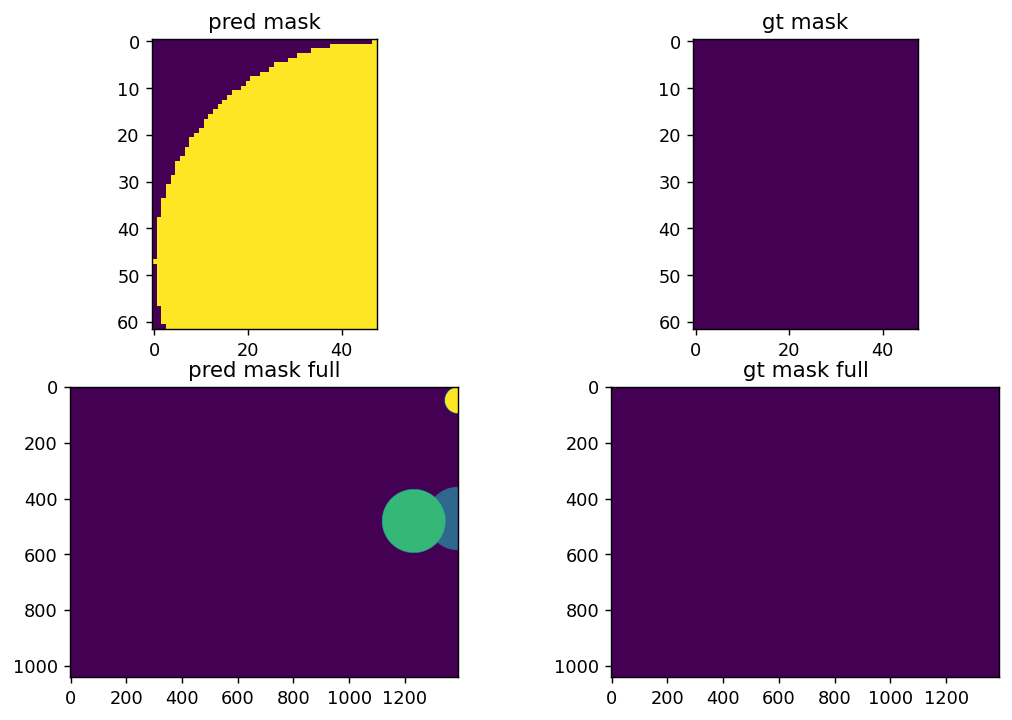

In [39]:
numSample2Show = 1
figWinNumHeight, figWinNumWidth = 3, 2
plt.figure(figsize=(10,10), dpi=128, facecolor='w', edgecolor='k') # figsize -- inch-by-inch
plt.clf()
subwinCount = 1    

plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
plt.imshow(crop_mask)
plt.title('pred mask')

plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
plt.imshow(crop_gt_mask)
plt.title('gt mask')

plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
plt.imshow(detMask)
plt.title('pred mask full')

plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
plt.imshow(curmask_OrgSize_binary)
plt.title('gt mask full')